In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Preparation

In [11]:
df = pd.read_csv("./datas/google_stock.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-11,98.250000,100.120003,97.250000,98.050003,98.050003,21617700
1,2022-10-12,98.269997,99.648003,97.669998,98.300003,98.300003,17343400
2,2022-10-13,95.930000,100.529999,95.269997,99.709999,99.709999,32812200
3,2022-10-14,100.625000,101.290001,97.029999,97.180000,97.180000,22624800
4,2022-10-17,99.519997,101.769997,99.510002,100.779999,100.779999,23311600


In [12]:
df = df[["Date", "Close"]]
df.head(5)

,Date,Close
0,2022-10-11,98.050003
1,2022-10-12,98.300003
2,2022-10-13,99.709999
3,2022-10-14,97.180000
4,2022-10-17,100.779999


In [13]:
# Change date type from string to date
import datetime

def str_to_date(str):
    split = str.split("-")
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df["Date"] = df["Date"].apply(str_to_date)
df["Date"].info()
df.index = df.pop('Date')

<class 'pandas.core.series.Series'>
RangeIndex: 251 entries, 0 to 250
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
251 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.1 KB


In [14]:
def windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_date(first_date_str)
    last_date  = str_to_date(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        # Create a small dataset for n+1 days
        df_subset = dataframe.loc[:target_date].tail(n+1)
        # print(df_subset.head(5))
    
        # If the n > dataset rows, raise error
        if len(df_subset) != n+1:
            print(f"Error: Window of size {n} is too large for date {target_date}")
            return

        # Store the close value of current date until date-n in x,y
        values = df_subset["Close"].to_numpy()
        x, y = values[:-1], values[-1]
        # print(values)

        # Append the date value and closing value
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Get the next day datas
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split("T")[0]
        year_month_day = next_date_str.split("-")
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        # print(next_date)
        
        # If we reach the last date, then stop
        if last_time:
            break
        
        # Else we contininue for the next date
        target_date = next_date

        # For last iteration
        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df["Target Date"] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f"Target-{n-i}"] = X[:, i]

    ret_df["Target"] = Y

    return ret_df

# Start day second time around: "2022-10-14"
df_target = windowed_df(df, "2022-10-14", "2023-10-10", n=3)
df_target.head(5)

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-10-14,98.050003,98.300003,99.709999,97.180000
1,2022-10-17,98.300003,99.709999,97.180000,100.779999
2,2022-10-18,99.709999,97.180000,100.779999,101.389999
3,2022-10-19,97.180000,100.779999,101.389999,100.290001
4,2022-10-20,100.779999,101.389999,100.290001,100.529999


In [15]:
def windowed_input(windowed_target):
  df_np = windowed_target.to_numpy()

  dates = df_np[:, 0].reshape(-1,1)

  x = df_np[:, 1:-1]

  y = df_np[:, -1].reshape(-1,1)

  return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = windowed_input(df_target)

dates.shape, x.shape, y.shape

((248, 1), (248, 3), (248, 1))

### Split The Data

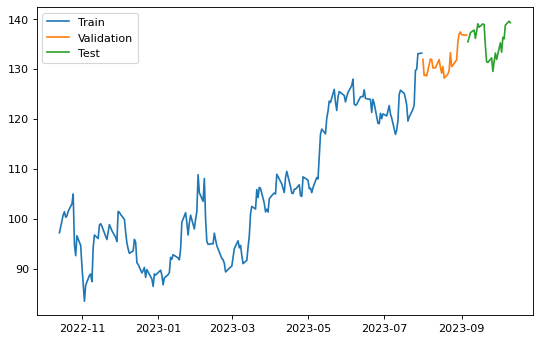

In [16]:
# Train data
q_80 = int(len(dates) * .8)
# Validation data
q_90 = int(len(dates) * .9)

dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]

dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.figure(figsize = (8,5), dpi = 80)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(["Train", "Validation", "Test"])
plt.show()

### LSTM Neural Network

In [20]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
    ])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["mean_absolute_error"])

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 137ms/step - loss: 11115.5469 - mean_absolute_error: 104.6506 - val_loss: 17152.2617 - val_mean_absolute_error: 130.9362
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 10970.2676 - mean_absolute_error: 103.9588 - val_loss: 17040.8145 - val_mean_absolute_error: 130.5099
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 10878.3242 - mean_absolute_error: 103.5158 - val_loss: 16911.8770 - val_mean_absolute_error: 130.0150
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 10760.2363 - mean_absolute_error: 102.9406 - val_loss: 16731.1777 - val_mean_absolute_error: 129.3182
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 10597.9219 - mean_absolute_error: 102.1504 - val_loss: 16486.5527 - val_mean_absolute_error: 128.3689
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 10381.9385 - mean_absolute_error: 101.0894 - val_loss: 16

### Predictions

7/7 [==============================] - 0s 3ms/step


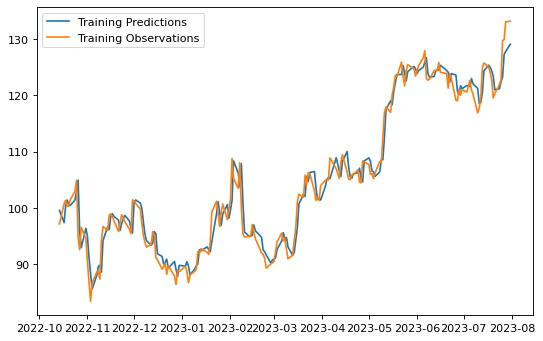

In [ ]:
train_pred = model.predict(x_train).flatten()

plt.figure(figsize = (8,5), dpi = 80)

plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.legend(["Training Predictions", "Training Observations"])
plt.show()

1/1 [==============================] - 0s 66ms/step


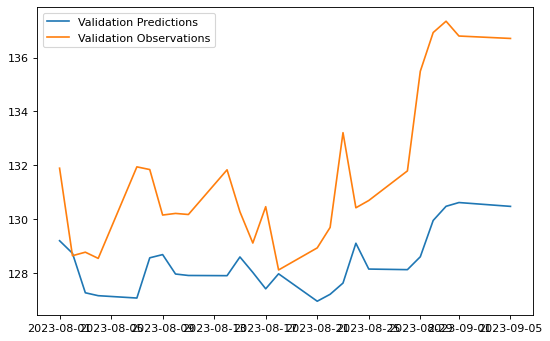

In [ ]:
val_pred = model.predict(x_val).flatten()

plt.figure(figsize = (8,5), dpi = 80)

plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.legend(["Validation Predictions", "Validation Observations"])
plt.show()

1/1 [==============================] - 0s 67ms/step


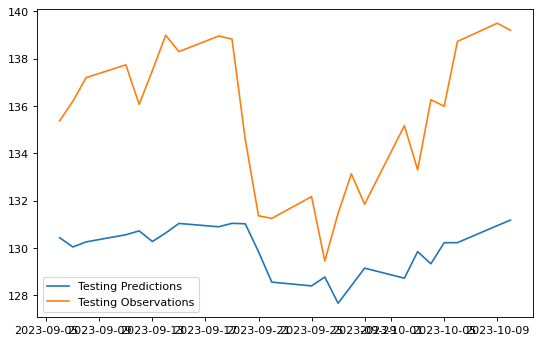

In [ ]:
test_pred = model.predict(x_test).flatten()

plt.figure(figsize = (8,5), dpi = 80)

plt.plot(dates_test, test_pred)
plt.plot(dates_test, y_test)
plt.legend(["Testing Predictions", "Testing Observations"])
plt.show()

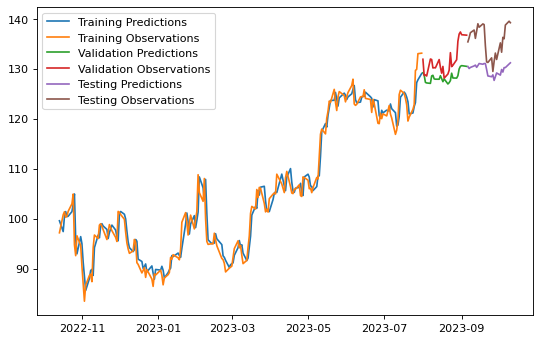

In [ ]:
plt.figure(figsize = (8,5), dpi = 80)

plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_pred)
plt.plot(dates_test, y_test)
plt.legend(["Training Predictions", 
            "Training Observations", 
            "Validation Predictions", 
            "Validation Observations", 
            "Testing Predictions", 
            "Testing Observations"])
plt.show()

### Recursive Prediction

In [ ]:
from copy import deepcopy

recursive_pred = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(x_train[-1])
  next_pred = model.predict(np.array([last_window])).flatten()
  recursive_pred.append(next_pred)
  last_window[-1] = next_pred

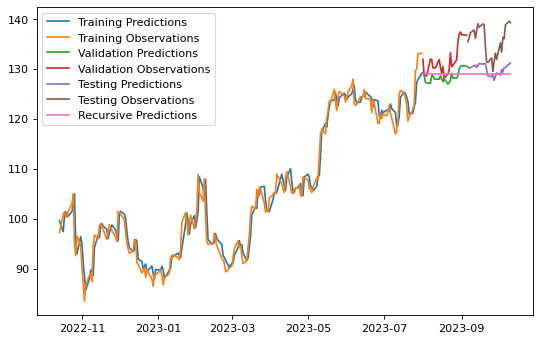

In [ ]:
plt.figure(figsize = (8,5), dpi = 80)

plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_pred)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_pred)
plt.legend(["Training Predictions",  
            "Training Observations", 
            "Validation Predictions",  
            "Validation Observations", 
            "Testing Predictions",  
            "Testing Observations", 
            "Recursive Predictions"])
plt.show()